# Neumann Boundary Condition

In [1]:
%load_ext autoreload
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

## Initialization

In [2]:
nx = 32
a,b = 0,1
bc_type = 'NBC'
omega = 10
oce_val = 0
gamma =3e-8

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

## Forcing Term

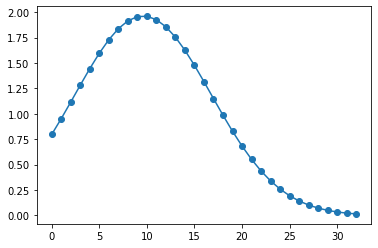

In [3]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')
plt.show()

## Boundary Condition

In [4]:
from numpy import cos, pi, sin, exp
u0L = 1.0#cos(0.0)*3*pi
u0R = 0.1 #cos(3*pi)*3*pi
print(f'u0L: {u0L}, u0R: {u0R}')
run.BC_setup(u0L, u0R)

u0L: 1.0, u0R: 0.1


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

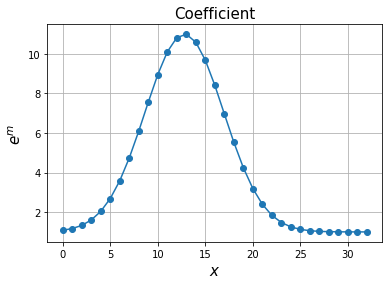

In [5]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)
run.mtrue_setup(mtrue)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Setup Data

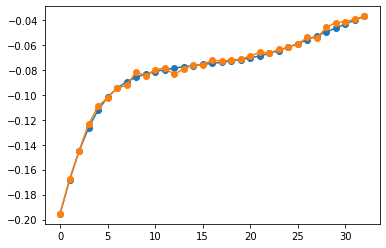

In [6]:
np.random.seed(0)
noise_level = 0.01
ud, goal_A, goal_b = run.fwd_solve(m)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values(),normalize = False)

plt.plot(utrue_array, 'o-')
plt.plot(run.ud.compute_vertex_values(), 'o-')
plt.show()

## Initial Guess and Initial Solution

In [8]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)

u,_,_ = run.fwd_solve(m)
print('left side: ',(u.compute_vertex_values()[1] - u.compute_vertex_values()[0])/run.mesh.hmax() * np.exp(m.compute_vertex_values()[0]) )
print('right side: ',(u.compute_vertex_values()[-1] - u.compute_vertex_values()[-2])/run.mesh.hmax() * np.exp(m.compute_vertex_values()[-1]) )
print('true left side: ', u0L)
print('true right side: ', u0R)

left side:  0.974941164642372
right side:  0.10007059749561598
true left side:  1.0
true right side:  0.1


## Optimization Loop

In [8]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     5.98540e-05   1.19708e-04   4.13175e-10   2.00753e-02   7.43249e-04   1.00e+00   5.000e-01
 2     1     4.58907e-05   9.17811e-05   2.46870e-10   4.76119e-03   1.75278e-04   1.00e+00   4.856e-01
 3     3     6.77250e-06   1.30168e-05   5.28165e-07   7.48885e-03   1.28996e-04   1.00e+00   4.166e-01
 4     1     5.34642e-06   1.01636e-05   5.29241e-07   1.73473e-03   6.90315e-05   1.00e+00   3.048e-01
 5     3     1.62463e-06   2.35646e-06   8.92806e-07   2.69254e-03   6.04510e-05   1.00e+00   2.852e-01
 6     2     1.59435e-06   2.29607e-06   8.92621e-07   2.42948e-04   8.47685e-06   1.00e+00   1.068e-01
 7    15     1.40149e-06   1.77679e-06   1.02618e-06   6.12673e-04   5.34385e-06   1.00e+00   8.479e-02
 8     2     1.39325e-06   1.76057e-06   1.02592e-06   1.27480e-04   3.40266e-06   1.00e+00   6.766e-02
 9    16     1.38433e-06   1.72091e-06   1.04776e-06   1.26843e-04   8.

## Plot Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


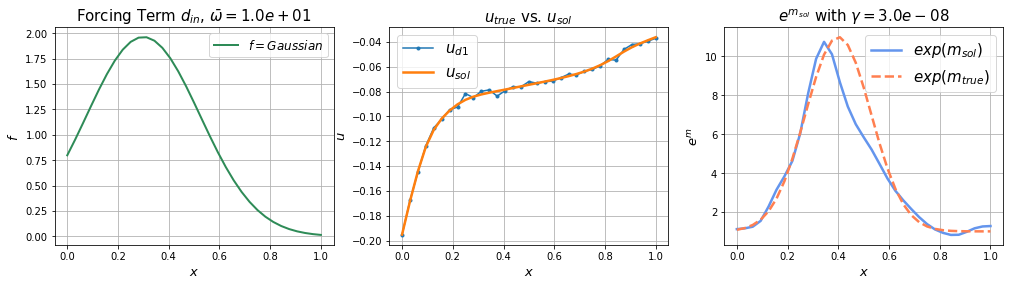

In [9]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$f$', fontsize=13)
ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# ax[0].legend()
ax[0].legend(prop={'size':12})

ax[1].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[1].plot(x, u.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_NB_synth.eps', format='eps',dpi=250)
plt.show()

# Dirichlet Boundary Condition

In [1]:
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

## Initialization

In [2]:
nx = 32
a,b = 0,1
bc_type = 'DBC'
omega = 10
oce_val = 0.0
gamma =3e-5

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx+self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx'
a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

## Forcing Term

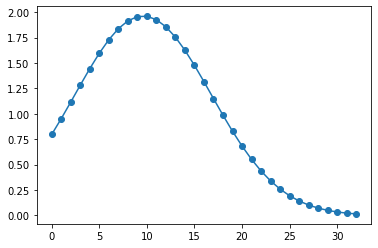

In [3]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

## Boundary Condition

In [4]:
from numpy import cos, pi, sin, exp
u0L = 0.0#cos(0.0)*3*pi
u0R = 1.0 #cos(3*pi)*3*pi
print(f'u0L: {u0L}, u0R: {u0R}')
run.BC_setup(u0L, u0R)

u0L: 0.0, u0R: 1.0


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

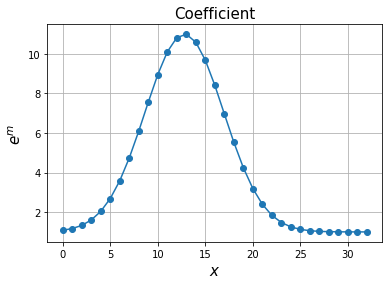

In [5]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)
run.mtrue_setup(mtrue)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Setup Data

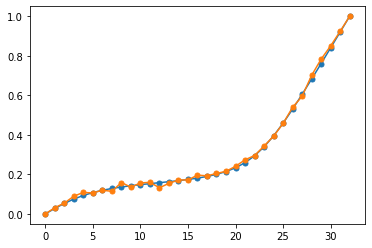

In [6]:
np.random.seed(0)
noise_level = 0.01
ud, goal_A, goal_b = run.fwd_solve(m)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values())

plt.plot(utrue_array, 'o-',markersize=5)
plt.plot(run.ud.compute_vertex_values(), 'o-',markersize=5)
plt.show()

## Initial Guess and Initial Solution

In [7]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u,_,_ = run.fwd_solve(m)
print(u.compute_vertex_values()[0])
print(u.compute_vertex_values()[-1])

0.0
1.0


## Optimization Loop

In [8]:
tol = 1e-9
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     1.75362e-03   3.48909e-03   1.81405e-05   1.15103e-01   3.37827e-02   1.00e+00   5.000e-01
 2     2     7.85145e-04   1.40428e-03   1.66010e-04   4.57876e-02   8.44484e-03   1.00e+00   5.000e-01
 3     1     6.64292e-04   1.17679e-03   1.51790e-04   1.54948e-02   5.52185e-03   1.00e+00   4.043e-01
 4     2     3.56893e-04   3.03443e-04   4.10344e-04   2.50671e-02   2.80898e-03   1.00e+00   2.884e-01
 5     2     3.43724e-04   2.66141e-04   4.21306e-04   5.03947e-03   9.47733e-04   1.00e+00   1.675e-01
 6     4     3.32006e-04   2.11172e-04   4.52840e-04   4.84633e-03   4.08099e-04   1.00e+00   1.099e-01
 7     4     3.31946e-04   2.13801e-04   4.50091e-04   3.36969e-04   3.73623e-05   1.00e+00   3.326e-02
 8     5     3.31943e-04   2.13476e-04   4.50409e-04   7.92547e-05   8.92979e-06   1.00e+00   1.626e-02
 9     7     3.31942e-04   2.13432e-04   4.50453e-04   5.64288e-06   7.

## Plotting Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


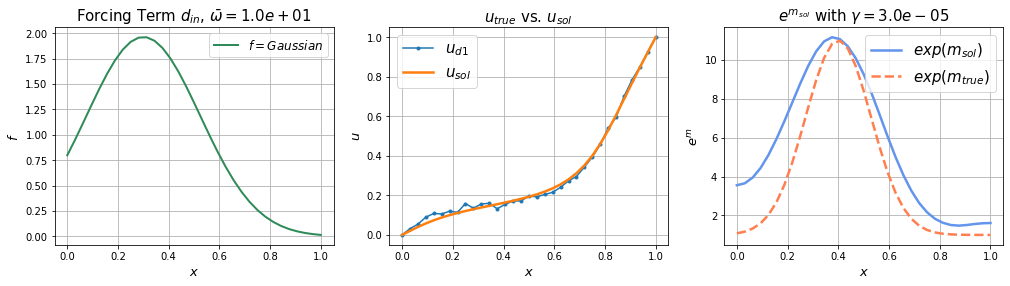

In [11]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$f$', fontsize=13)
ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# ax[0].legend()
ax[0].legend(prop={'size':12})

ax[1].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[1].plot(x, u.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_DB_synth.eps', format='eps',dpi=250)
plt.show()

# Dual Data Problem

In [1]:
from helm_eq import dual_data_run
import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

## Initialization

In [30]:
nx = 32
a,b = 0,1
omega = 10
oce_val1 = 0.0
oce_val2 = 0.0
gamma =3e-8

beta1 = 0.0
beta2 = 1.0

run = dual_data_run(nx, a, b, gamma, omega, omega, oce_val1, oce_val2, normalized_mean1=oce_val1,normalized_mean2=oce_val2, beta1=beta1, beta2 = beta2)
x = run.mesh.coordinates()

In [31]:
a1_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val1 * self.u_trial * self.u_test * ufl.dx'
L1_state_str = 'self.f * self.omega_val1 * self.u_oce_val1 * self.u_test * ufl.dx'
a1_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val1 * self.p_trial * self.p_test * ufl.dx'
L1_adj_str = '-ufl.inner(u1 - self.ud1, self.p_test) * ufl.dx'

a2_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val2 * self.u_trial * self.u_test * ufl.dx'
L2_state_str = 'self.f * self.omega_val2 * self.u_oce_val2 * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a2_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val2 * self.p_trial * self.p_test * ufl.dx'
L2_adj_str = '-ufl.inner(u2 - self.ud2, self.p_test) * ufl.dx'

run.state_adj_str_setup(a1_state_str, L1_state_str,a1_adj_str, L1_adj_str,  a2_state_str, L2_state_str,  a2_adj_str, L2_adj_str)

## Forcing Term

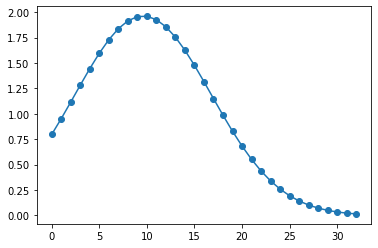

In [32]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

## Boundary Condition

In [33]:
from numpy import cos, pi, sin, exp
u1L_D = 0.0#cos(0.0)*3*pi
u1R_D = 1.0 #cos(3*pi)*3*pi
u2L_N = 1.0
u2R_N = 0.1
print(f'Dirichlet_L: {u1L_D}, Dirichlet_R: {u1R_D}, NBC_L: {u2L_N}, NBC_R: {u2R_N}')
run.BC_setup(u1L_D, u1R_D, u2L_N, u2R_N)

Dirichlet_L: 0.0, Dirichlet_R: 1.0, NBC_L: 1.0, NBC_R: 0.1


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

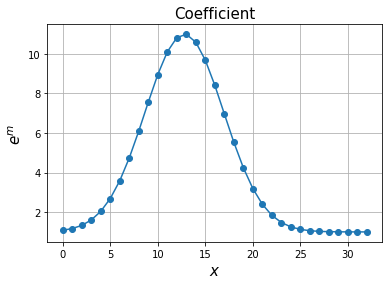

In [34]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)
run.mtrue_setup(mtrue)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Setup Data

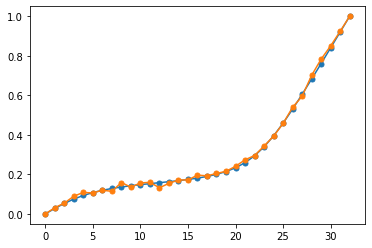

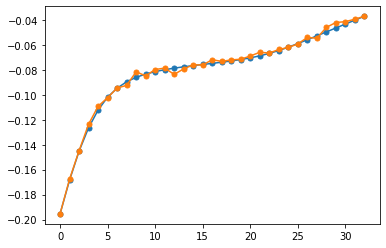

In [35]:

noise_level = 0.01
ud1, ud2, goal_A1, goal_b1, goal_A2, goal_b2 = run.fwd_solve(m)
utrue1_array = ud1.compute_vertex_values()
utrue2_array = ud2.compute_vertex_values()
from utils.general import apply_noise
np.random.seed(0)
apply_noise(noise_level, ud1, goal_A1)
np.random.seed(0)
apply_noise(noise_level, ud2, goal_A2)
run.data_setup(ud1.compute_vertex_values(), ud2.compute_vertex_values(),normalize=False)

plt.plot(utrue1_array, 'o-',markersize=5)
plt.plot(run.ud1.compute_vertex_values(), 'o-',markersize=5)
plt.show()
plt.plot(utrue2_array, 'o-',markersize=5)
plt.plot(run.ud2.compute_vertex_values(), 'o-',markersize=5)
plt.show()

## Initial Guess and Initial Solution

In [36]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u1,u2,_,_,_,_ = run.fwd_solve(m)
print(u1.compute_vertex_values()[0])
print(u1.compute_vertex_values()[-1])
print((u2.compute_vertex_values()[1] - u2.compute_vertex_values()[0])/run.mesh.hmax())
print((u2.compute_vertex_values()[-1] - u2.compute_vertex_values()[-2])/run.mesh.hmax())

0.0
1.0
0.487470582321186
0.05003529874780799


## Optimization Loop

In [37]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%Y%m%d-%H%M%S")
print(dt_string)

20230906-132253


In [38]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u1, u2 = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     5.98540e-05   1.19708e-04   4.13175e-10   2.00753e-02   7.43249e-04   1.00e+00   5.000e-01
 2     1     4.58907e-05   9.17811e-05   2.46870e-10   4.76119e-03   1.75278e-04   1.00e+00   4.856e-01
 3     3     6.77250e-06   1.30168e-05   5.28165e-07   7.48885e-03   1.28996e-04   1.00e+00   4.166e-01
 4     1     5.34642e-06   1.01636e-05   5.29241e-07   1.73473e-03   6.90315e-05   1.00e+00   3.048e-01
 5     3     1.62463e-06   2.35646e-06   8.92806e-07   2.69254e-03   6.04510e-05   1.00e+00   2.852e-01
 6     2     1.59435e-06   2.29607e-06   8.92621e-07   2.42948e-04   8.47685e-06   1.00e+00   1.068e-01
 7    15     1.40149e-06   1.77679e-06   1.02618e-06   6.12673e-04   5.34385e-06   1.00e+00   8.479e-02
 8     2     1.39325e-06   1.76057e-06   1.02592e-06   1.27480e-04   3.40266e-06   1.00e+00   6.766e-02
 9    16     1.38433e-06   1.72091e-06   1.04776e-06   1.26843e-04   8.

## Plotting Results

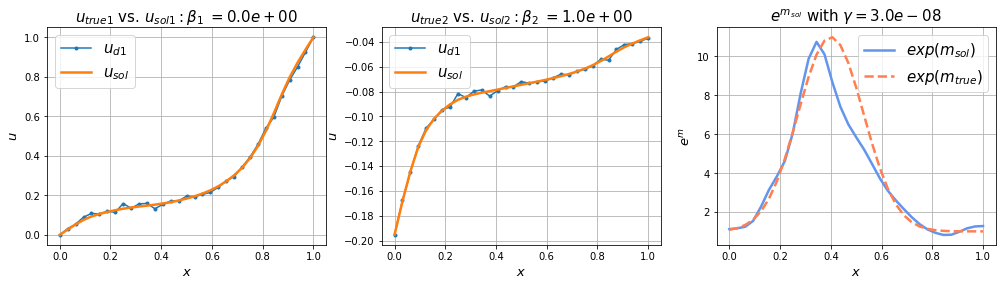

In [39]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, run.ud1.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[0].plot(x, u1.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true1}$ vs. $u_{sol1}: \beta_1$' + f' $ = {beta1:1.1e}$', fontsize=15)
ax[0].legend(prop={'size':15})

ax[1].plot(x, run.ud2.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[1].plot(x, u2.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true2}$ vs. $u_{sol2}: \beta_2$' + f' $ = {beta2:1.1e}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/dual_helm_synth_{beta1:1.1f}_{beta2:1.1f}.eps', format='eps',dpi=250)
plt.show()

# Construct a Dual Problem

## single data DBC or NBC

In [1]:
from helm_eq import single_data_run
import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
nx = 32
a,b = 0,1
bc_type = 'DBC'
omega = 1.0
oce_val = 1.0
gamma =1.043e-4 if bc_type == 'DBC' else 1.6e-3
gamma = 1.0e-4
run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=0.0)
run.misfit_reg_setup(gamma)

if bc_type == 'DBC':
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx+self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g * self.u_test * ufl.dx'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
elif bc_type == 'NBC':
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

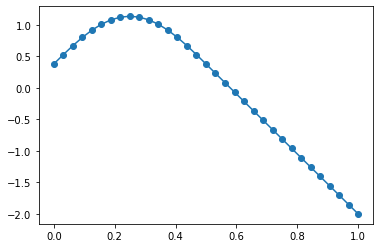

In [ ]:
from numpy import cos, sin, exp, pi
x = np.linspace(a,b,nx+1)

y = sin(2* pi * x)
y_lin = -2 * pi * x +  pi
y1 = y.copy()
y2 = y.copy()
if bc_type == 'DBC':
    y1[x>=0.5] = y_lin[x>=0.5]
elif bc_type == 'NBC':
    y1[x<=0.5] = y_lin[x<=0.5]
else:
    raise ValueError(f'Unknown BC type: {bc_type}')

def normalize_u(u_array):
    mean = np.mean(u_array)
    std = np.std(u_array)
    return (u_array - mean) / std, mean, std

y1, _, _ = normalize_u(y1)
dy1 = np.gradient(y1,x,edge_order=2)

plt.plot(x, y1, 'o-')

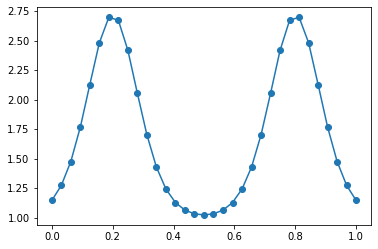

In [ ]:
def gaussian(x, mean, std):
    return np.exp(-np.power(x - mean, 2.) / (2 * np.power(std, 2.)))

mtrue_array = gaussian(x, 0.2, 0.1) + gaussian(x, 0.8, 0.1)
# mtrue_array = np.log(1 + 10 * gaussian(x, 0.4, 1/np.sqrt(60)))
# mtrue_array = np.zeros_like(x)
m_true = dl.Function(run.Vm)
m_true.vector().set_local(mtrue_array[::-1])
run.mtrue_setup(m_true)
plt.plot(x, np.exp(run.mtrue.compute_vertex_values()), 'o-')


### Setup Forcing

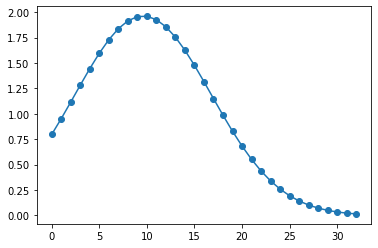

In [ ]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
forcing_array = f.compute_vertex_values()
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

### Setup BC

In [ ]:
uL = y1[0] if bc_type == 'DBC' else dy1[0] * np.exp(mtrue_array[0])
uR = y1[-1] if bc_type == 'DBC' else dy1[-1] * np.exp(mtrue_array[-1])
print(f'uL: {uL}, uR: {uR}')
run.BC_setup(uL, uR)

uL: 0.38035497335598545, uR: -2.0022128858133064


### Set up extra Forcing

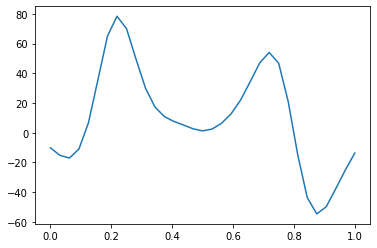

In [ ]:
g_array = - np.gradient( np.exp(mtrue_array) * np.gradient(y1, x, edge_order=2) , x, edge_order=2) \
            + forcing_array * omega * (y1 - oce_val)

g = dl.Function(run.Vu)
g.vector().set_local(g_array[::-1])
run.extra_f_setup(g = g)

plt.plot(x,run.g.compute_vertex_values())
plt.show()

### Setup Data


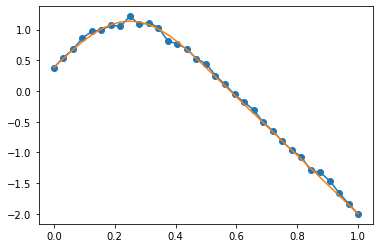

In [ ]:
noise_level = 0.02
ud, goal_A, goal_b = run.fwd_solve(m_true)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
np.random.seed(0)
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values(),normalize = False)

plt.plot(x, run.ud.compute_vertex_values(), 'o-')
plt.plot(x, y1)

### Initial Guess

0.38035497335598545
-2.0022128858133064
0.38035497335598545 -2.0022128858133064


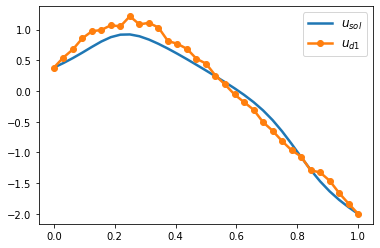

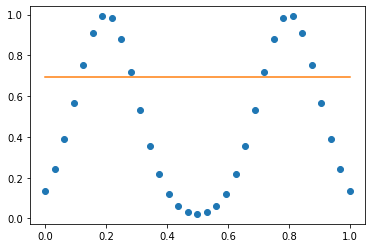

In [ ]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u,_,_ = run.fwd_solve(m)
if bc_type == 'DBC':
    print(u.compute_vertex_values()[0])
    print(u.compute_vertex_values()[-1])
    print(y1[0], y1[-1])
elif bc_type == 'NBC':
    print((u.compute_vertex_values()[1] - u.compute_vertex_values()[0])/run.mesh.hmax() * np.exp(mtrue_array[0]))
    print((u.compute_vertex_values()[-1] - u.compute_vertex_values()[-2])/run.mesh.hmax() * np.exp(mtrue_array[-1]))
    print(uL, uR)

plt.plot(x,u.compute_vertex_values(), label=r'$u_{sol}$',linewidth=2.5)
plt.plot(x,run.ud.compute_vertex_values(),'o-', label=r'$u_{d1}$',linewidth=2.5)
plt.legend(prop={'size':12})
plt.show()

plt.plot(x,mtrue_array, 'o')
plt.plot(x, m.compute_vertex_values())

### Optimization Loop

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg


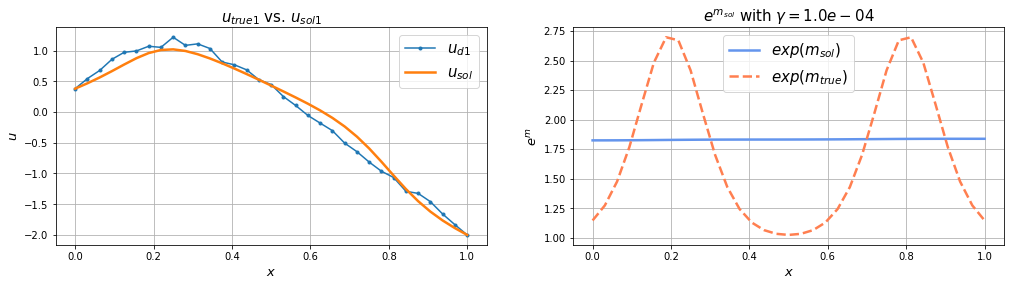

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     9.65752e-03   1.93150e-02   7.88822e-09   7.18538e-02   7.28839e-02   1.00e+00   5.000e-01


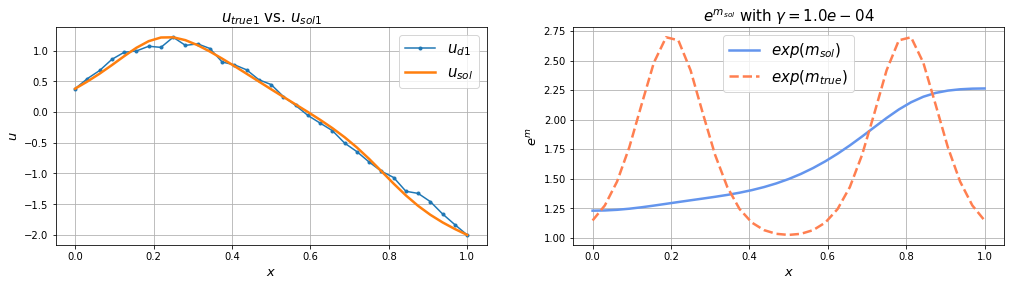

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 2     2     3.18358e-03   6.31277e-03   5.43765e-05   1.14420e-01   8.13838e-02   1.00e+00   5.000e-01


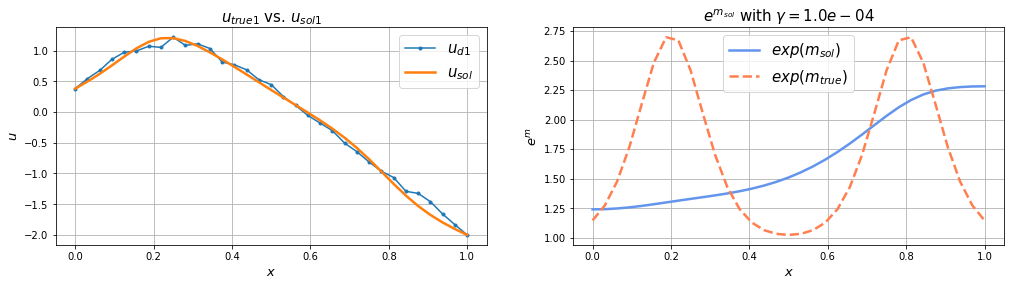

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 3     1     3.14286e-03   6.23140e-03   5.43178e-05   9.02690e-03   2.49562e-02   1.00e+00   5.000e-01


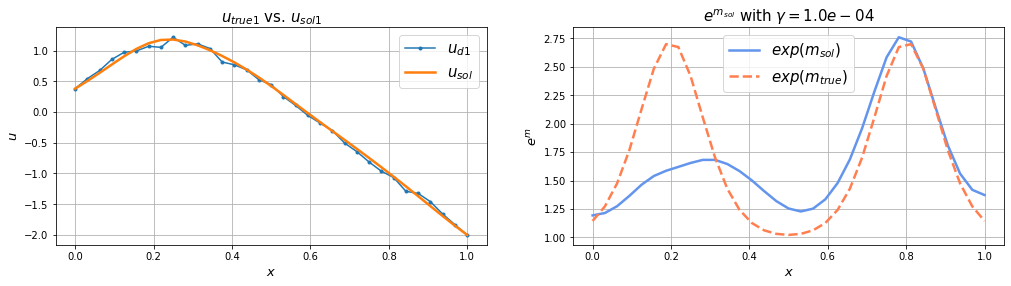

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 4     5     1.34171e-03   1.97550e-03   7.07918e-04   6.26528e-02   2.20228e-02   1.00e+00   5.000e-01


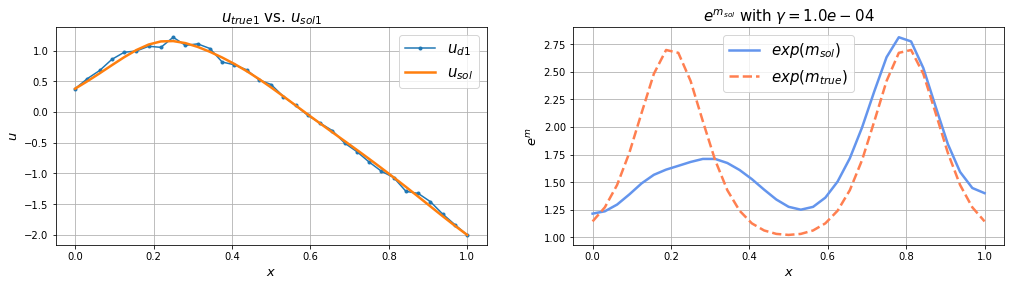

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 5     1     1.16715e-03   1.62603e-03   7.08263e-04   1.86878e-02   2.67160e-02   1.00e+00   5.000e-01


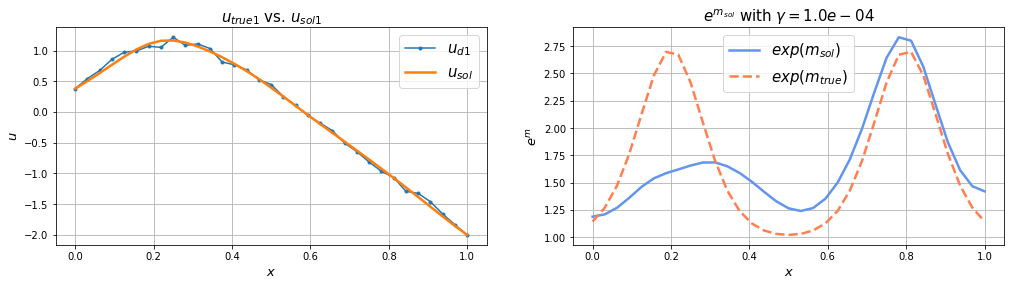

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 6     2     1.14044e-03   1.56800e-03   7.12876e-04   7.32783e-03   7.40591e-03   1.00e+00   3.188e-01


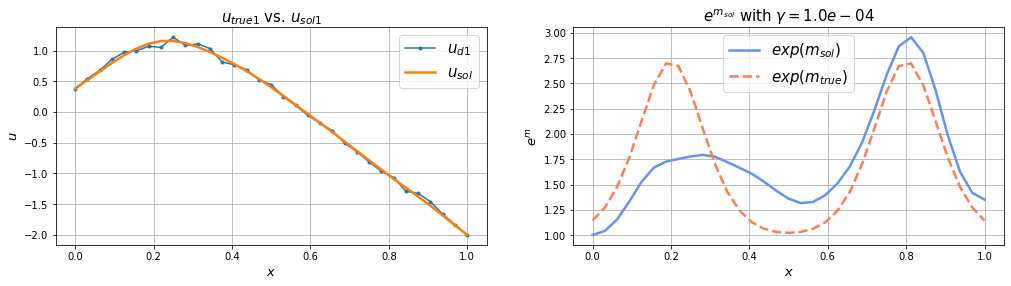

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 7     6     1.01159e-03   1.08387e-03   9.39302e-04   1.61323e-02   5.07821e-03   1.00e+00   2.640e-01


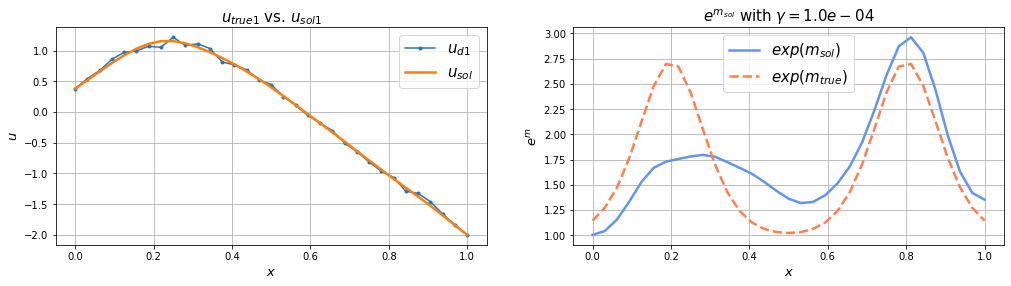

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 8     1     1.00975e-03   1.08020e-03   9.39290e-04   1.91653e-03   2.74954e-03   1.00e+00   1.942e-01


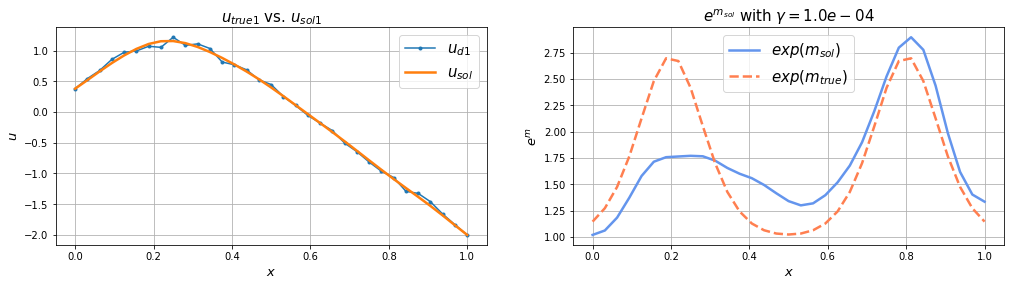

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 9     8     1.00426e-03   1.08246e-03   9.26060e-04   3.31845e-03   9.93228e-04   1.00e+00   1.167e-01


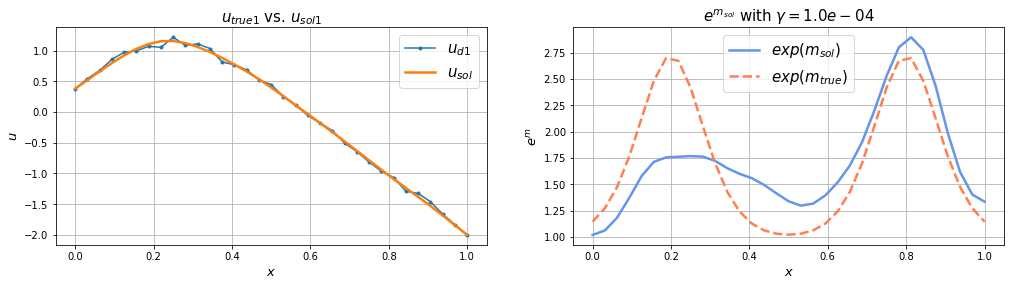

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
10     5     1.00423e-03   1.08462e-03   9.23839e-04   2.34819e-04   1.01903e-04   1.00e+00   3.739e-02


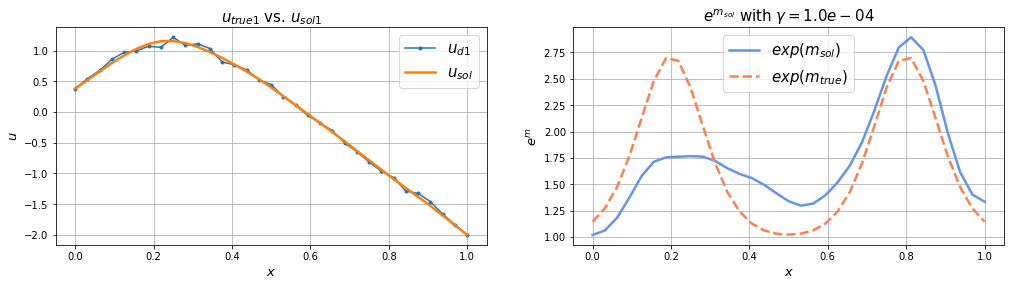

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
11    11     1.00423e-03   1.08423e-03   9.24228e-04   6.94907e-05   2.63357e-05   1.00e+00   1.901e-02


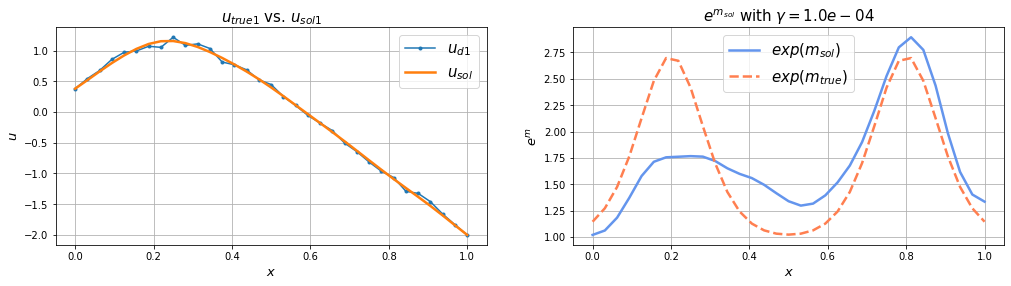

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
12    17     1.00423e-03   1.08423e-03   9.24229e-04   6.47057e-07   2.64730e-07   1.00e+00   1.906e-03


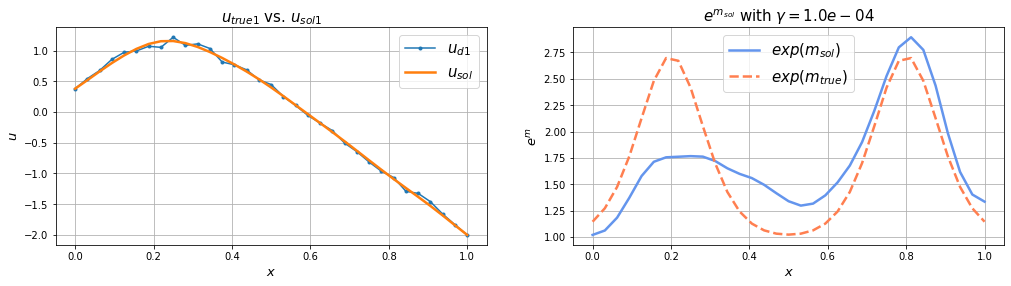

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
13    14     1.00423e-03   1.08423e-03   9.24229e-04   2.46123e-10   9.78343e-11   1.00e+00   3.664e-05


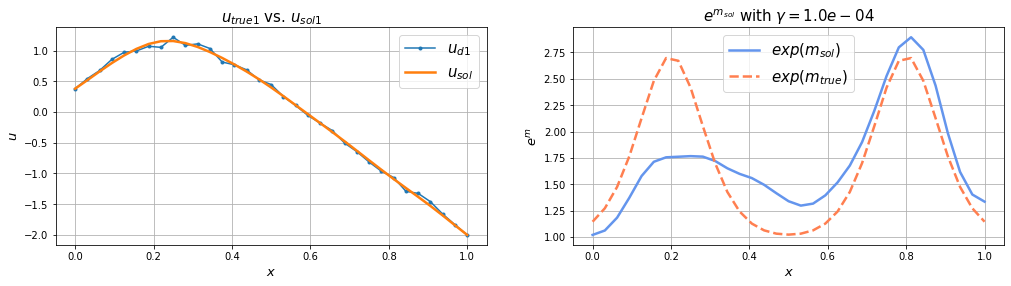

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
14     0     1.00423e-03   1.08423e-03   9.24229e-04   -0.00000e+00   1.48479e-13   9.77e-04   1.427e-06
Newton's method converged in  14   iterations
Total number of CG iterations:  74


In [ ]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter,plot_opt_step=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


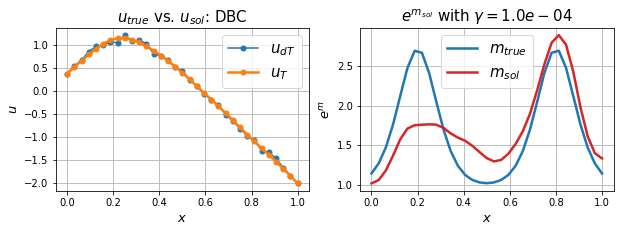

In [ ]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,3),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

# ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
# ax[0].grid('on')
# ax[0].set_xlabel(r'$x$', fontsize=13)
# ax[0].set_ylabel(r'$f$', fontsize=13)
# ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# # ax[0].legend()
# ax[0].legend(prop={'size':12})

if bc_type == 'DBC':
    ax[0].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{dT}$', markersize=5)
    label = r'$u_{T}$'
elif bc_type == 'NBC':
    ax[0].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{dS}$', markersize=5)
    label = r'$u_{S}$'
else:
    raise ValueError(f'Unknown BC type: {bc_type}')
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)

ax[0].plot(x, u.compute_vertex_values(), 'o-', markersize=5, label=label,linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true}$ vs. $u_{sol}$: '+ f'{bc_type}', fontsize=15)
ax[0].legend(prop={'size':15})

text = ax[1].yaxis.get_offset_text()
text.set_fontsize(8)
# ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
# ax[2].plot(x, np.exp(m_true.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[1].plot(x,np.exp(m_true.compute_vertex_values()), '-', label=r'$m_{true}$', linewidth=2.5,color = 'tab:blue')
ax[1].plot(x,np.exp(m.compute_vertex_values()), '-', label=r'$m_{sol}$', linewidth=2.5,color = 'tab:red')
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$e^m$', fontsize=13)
ax[1].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[1].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_DB_synth.eps', format='eps',dpi=250)
eps = True
if not eps:
    if bc_type == 'DBC':
        plt.savefig(f'./log/img/helm_DB_synth.png',dpi=250)
    elif bc_type == 'NBC':
        plt.savefig(f'./log/img/helm_NB_synth.png',dpi=250)
else:
    if bc_type == 'DBC':
        plt.savefig(f'./log/img/helm_DB_synth.eps',format='eps',dpi=250,bbox_inches='tight')
    elif bc_type == 'NBC':
        plt.savefig(f'./log/img/helm_NB_synth.eps',format='eps',dpi=250,bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


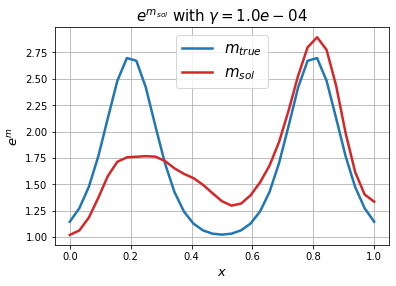

In [ ]:
plt.plot(x,np.exp(m_true.compute_vertex_values()), '-', label=r'$m_{true}$', linewidth=2.5,color = 'tab:blue')
plt.plot(x,np.exp(m.compute_vertex_values()), '-', label=r'$m_{sol}$', linewidth=2.5,color = 'tab:red')
plt.grid('on')
plt.xlabel(r'$x$', fontsize=13)
plt.ylabel(r'$e^m$', fontsize=13)
plt.title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
plt.legend(prop={'size':15})
plt.savefig(f'./log/img/helm_{bc_type}_synth.eps',format='eps',dpi=250)

### Eigenvalue of Hess

In [ ]:
k = run.nx
lmbda, evecs = run.eigenvalue_request(m, p=20)
if bc_type == 'DBC':
    DBC_eig = lmbda.copy()
elif bc_type == 'NBC':
    NBC_eig = lmbda.copy()
else:
    raise ValueError(f'Unknown BC type: {bc_type}')

# plt.plot(range(0,k+1), np.ones(k+1), '-r')
# plt.plot(range(0,k), lmbda, 'b*')
# if 'DBC_eig' in locals():
#     plt.plot(range(0,k), DBC_eig, '*', label='DBC Hess Eig')
# if 'NBC_eig' in locals():
#     plt.plot(range(0,k), NBC_eig, '*', label='NBC Hess Eig')
# plt.legend()
# plt.yscale('log')
# plt.xlabel('number')
# plt.ylabel('eigenvalue')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


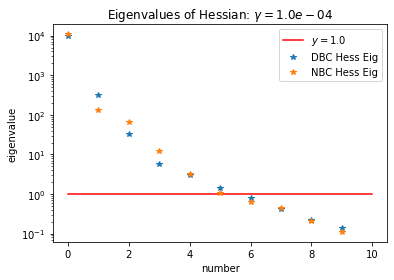

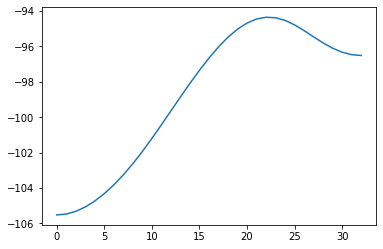

In [ ]:
cutoff_num = 1.0
# print(f'num DBC_eig (eig>{cutoff_num}): ', sum(DBC_eig-1>=cutoff_num))
# print(f'num NBC_eig (eig>{cutoff_num}): ', sum(NBC_eig-1>=cutoff_num))
# print(f'num dual_eig (eig>{cutoff_num}): ', sum(dual_eig-1>=cutoff_num))

k = 10
plt.plot(range(0,k+1), np.ones(k+1)*cutoff_num, '-r',label=f'$y={cutoff_num}$')
if 'DBC_eig' in locals():
    plt.plot(range(0,k), (DBC_eig-1)[:k], '*', label='DBC Hess Eig')
if 'NBC_eig' in locals():
    plt.plot(range(0,k), (NBC_eig-1)[:k], '*', label='NBC Hess Eig')
if 'dual_eig' in locals():
    plt.plot(range(0,k), (dual_eig-1)[:k], 'b*', label='Double Data Eig')
# plt.ylim([0.5,1.5])
plt.legend()
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')
plt.title(f'Eigenvalues of Hessian: $\gamma = {gamma:1.1e}$')
plt.savefig('./log/img/eigenvalues_singledata.eps', format='eps',dpi=250)
plt.show()

plt.plot(evecs[0])

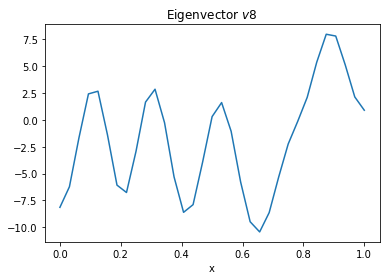

In [ ]:
idx = 8
plt.plot(x,evecs[idx])
plt.xlabel('x')
plt.title(f'Eigenvector $v{idx}$')
plt.savefig(f'./log/img/{bc_type}_eigvec{idx}.eps', format='eps', bbox_inches='tight',dpi=300)
# plt.savefig(f'./log/img/eigvec{idx}.eps', format='eps',dpi=250)

## Double Data 

In [1]:
from helm_eq import dual_data_run
import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

### Initialization


In [2]:
nx = 32
a,b = 0,1
omega = 1.0
oce_val = 0.0
gamma1 = 1.0e-4 #1.048e-4
gamma2 = 1.0e-4 #1.6e-3
print(f'gamma1   = {gamma1}, gamma2 = {gamma2}')
run = dual_data_run(nx,a,b,gamma1, gamma2, omega,omega,oce_val,oce_val, normalized_mean1=0.0, normalized_mean2=0.0)

beta1 = 0.5
beta2 = 0.5
run.misfit_reg_setup(beta1, beta2)

a1_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val1 * self.u_trial * self.u_test * ufl.dx'
L1_state_str = 'self.f * self.omega_val1 * self.u_oce_val1 * self.u_test * ufl.dx + self.g1 * self.u_test * ufl.dx'
a1_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val1 * self.p_trial * self.p_test * ufl.dx'
L1_adj_str = '-ufl.inner(u1 - self.ud1, self.p_test) * ufl.dx'

a2_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val2 * self.u_trial * self.u_test * ufl.dx'
L2_state_str = 'self.f * self.omega_val2 * self.u_oce_val2 * self.u_test * ufl.dx + self.g2 * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a2_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val2 * self.p_trial * self.p_test * ufl.dx'
L2_adj_str = '-ufl.inner(u2 - self.ud2, self.p_test) * ufl.dx'

run.state_adj_str_setup(a1_state_str, L1_state_str, a1_adj_str, L1_adj_str, a2_state_str, L2_state_str, a2_adj_str, L2_adj_str)

gamma1   = 0.0001, gamma2 = 0.0001


### Set up $u_{data}$ without noise

y1 mean: -1.3457248783335231e-17, y1 std: 1.3185742607495525
y2 mean: 1.682156097916904e-17, y2 std: 1.3185742607495528


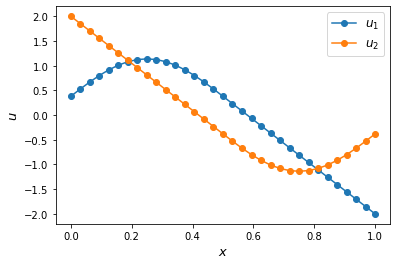

In [3]:
from numpy import cos, sin, exp, pi
x = np.linspace(a,b,nx+1)

y = sin(2* pi * x)
y_lin = -2 * pi * x +  pi
y1 = y.copy()
y2 = y.copy()

y1[x>=0.5] = y_lin[x>=0.5]
y2[x<=0.5] = y_lin[x<=0.5]


def normalize_u(u_array):
    mean = np.mean(u_array)
    std = np.std(u_array)
    return (u_array - mean) / std, mean, std

y1, y1_mean, y1_std = normalize_u(y1)
y2, y2_mean, y2_std = normalize_u(y2)

# run.u_oce1 = (run.u_oce1 - y1_mean) / y1_std
# run.u_oce_val1 = dl.Constant(f'{run.u_oce1}')
# run.u_oce2 = (run.u_oce2 - y2_mean) / y2_std
# run.u_oce_val2 = dl.Constant(f'{run.u_oce2}')

print(f'y1 mean: {y1.mean()}, y1 std: {y1_std}')
print(f'y2 mean: {y2.mean()}, y2 std: {y2_std}')

    
dy1 = np.gradient(y1,x,edge_order=2)
dy2 = np.gradient(y2,x,edge_order=2)

plt.plot(x, y1, 'o-', label=r'$u_1$')
plt.plot(x, y2, 'o-', label=r'$u_2$')
plt.legend(prop={'size':12})
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$u$', fontsize=13)
# plt.savefig('./log/img/double_data_setupt.eps', bbox_inches='tight',format='eps')
plt.show()

### Setup $m_{true}$

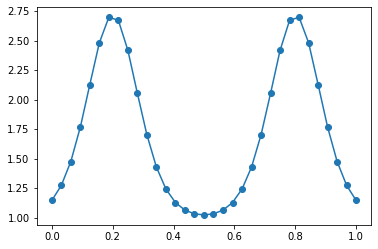

In [4]:
def gaussian(x, mean, std):
    return np.exp(-np.power(x - mean, 2.) / (2 * np.power(std, 2.)))

mtrue_array = gaussian(x, 0.2, 0.1) + gaussian(x, 0.8, 0.1)
# mtrue_array = np.log(1 + 10 * gaussian(x, 0.4, 1/np.sqrt(60)))
# mtrue_array = np.zeros_like(x)
m_true = dl.Function(run.Vm)
m_true.vector().set_local(mtrue_array[::-1])
run.mtrue_setup(m_true)
plt.plot(x, np.exp(run.mtrue.compute_vertex_values()), 'o-')


### Setup Forcing

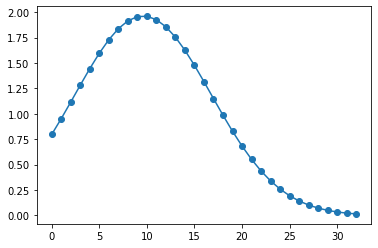

In [5]:

from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
forcing_array = f.compute_vertex_values()
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

### BC setup

In [6]:
from numpy import cos, pi, sin, exp
u1L_D = y1[0]
u1R_D = y1[-1]
u2L_N = dy2[0] * np.exp(mtrue_array[0])
u2R_N = dy2[-1] * np.exp(mtrue_array[-1])
print(f'Dirichlet_L: {u1L_D}, Dirichlet_R: {u1R_D},')
print(f'NBC_L: {u2L_N}, NBC_R: {u2R_N}')
run.BC_setup(u1L_D, u1R_D, u2L_N, u2R_N)

Dirichlet_L: 0.38035497335598545, Dirichlet_R: -2.0022128858133064,
NBC_L: -5.455702010876427, NBC_R: 5.5248712770988275


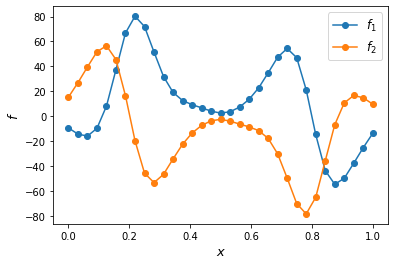

In [7]:
g1_array = - np.gradient( np.exp(mtrue_array) * np.gradient(y1, x, edge_order=2) , x, edge_order=2) \
            + forcing_array * omega * (y1 - oce_val)

g1 = dl.Function(run.Vu)
g1.vector().set_local(g1_array[::-1])

g2_array = - np.gradient( np.exp(mtrue_array) * np.gradient(y2, x, edge_order=2) , x, edge_order=2) \
            + forcing_array * omega * (y2 - oce_val)
g2 = dl.Function(run.Vu)
g2.vector().set_local(g2_array[::-1])
run.extra_f_setup(g1 = g1, g2 = g2)

plt.plot(x,run.g1.compute_vertex_values(),'o-',label=r'$f_1$')
plt.plot(x,run.g2.compute_vertex_values(),'o-',label=r'$f_2$')
plt.legend(prop={'size':12})
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$f$', fontsize=13)
# plt.savefig('./log/img/double_data_setupt_forcing.eps', bbox_inches='tight',format='eps')
plt.show()

-0.1367524594063987


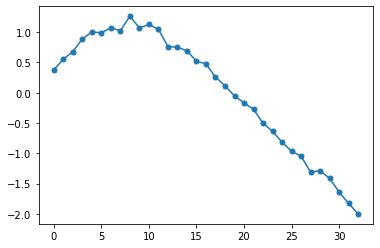

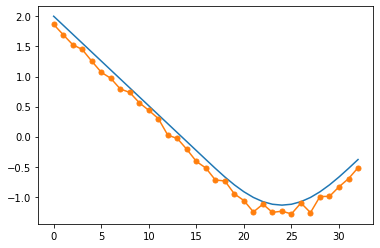

In [8]:
noise_level = 0.03

run.data_setup(y1, y2 ,normalize=False)
from utils.general import apply_noise
ud1, ud2, A1, b1, A2, b2 = run.fwd_solve(m_true)
np.random.seed(0)
apply_noise(noise_level, ud1, A1)
np.random.seed(1)
apply_noise(noise_level, ud2, A2)
run.data_setup(ud1.compute_vertex_values(), ud2.compute_vertex_values(), normalize=False)


# plt.plot(y1, '-',markersize=5)
print(np.mean(run.ud2.compute_vertex_values()))
plt.plot(run.ud1.compute_vertex_values(), 'o-',markersize=5)
plt.show()
plt.plot(y2, '-',markersize=5)
plt.plot(run.ud2.compute_vertex_values(), 'o-',markersize=5)
plt.show()

### Initial Guess

Text(0, 0.5, '$u_2$')

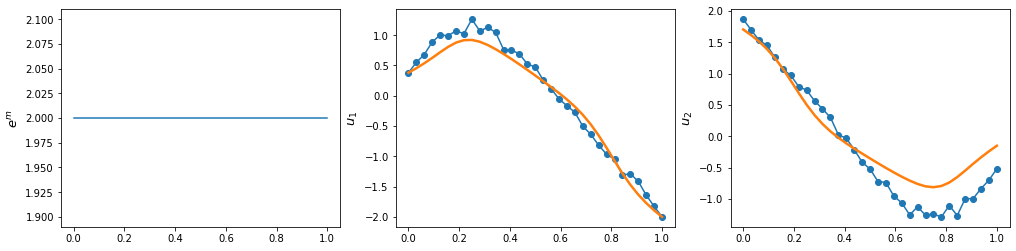

In [9]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(m_true)
u1,u2,_,_,_,_ = run.fwd_solve(m)
# print(u1.compute_vertex_values()[0])
# print(u1.compute_vertex_values()[-1])
# print((u2.compute_vertex_values()[1] - u2.compute_vertex_values()[0])/run.mesh.hmax())
# print((u2.compute_vertex_values()[-1] - u2.compute_vertex_values()[-2])/run.mesh.hmax())
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
ax[0].plot(x, np.exp(m.compute_vertex_values()))
ax[0].set_ylabel('$e^m$', fontsize=13)

ax[1].plot(x, run.ud1.compute_vertex_values(), '-o')
ax[1].plot(x, u1.compute_vertex_values(), linewidth=2.5)
ax[1].set_ylabel('$u_1$', fontsize=13)

ax[2].plot(x, run.ud2.compute_vertex_values(), '-o')
ax[2].plot(x, u2.compute_vertex_values(),linewidth=2.5)
ax[2].set_ylabel('$u_2$', fontsize=13)

0.28125


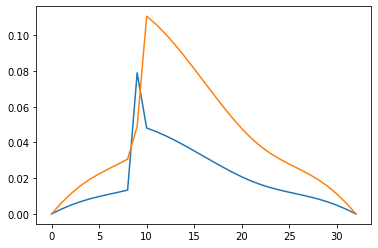

In [10]:
from utils.general import sensitivity_array
# mtrue_array = mtrue.compute_vertex_values()
utrue1_array = run.ud1.compute_vertex_values()
utrue2_array = run.ud2.compute_vertex_values()
sensitivity1 = sensitivity_array(mtrue_array, utrue1_array)
sensitivity2 = sensitivity_array(mtrue_array, utrue2_array)

# X = Y = np.arange(0,1,1/33)
# X, Y = np.meshgrid(X, Y)

# %matplotlib widget
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# surf = ax.plot_surface(X, Y, sensitivity, cmap="viridis")

%matplotlib inline
i = 24 # this is at x = 0.75
i = 9

print(i*run.mesh.hmax())
plt.plot(abs(sensitivity1[i,:]))
plt.plot(abs(sensitivity2[i,:]))

### Optimization Loop

In [11]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u1, u2 = run.opt_loop(m, tol, c, maxiter, save_opt_log=False, plot_opt_step=False, plot_eigval=False)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1    105   2.65041e-02   5.30078e-02   3.24868e-07   2.01910e-01   1.73255e-01   1.00000e+00   1.00e+00   5.000e-01
 2      1   2.45658e-02   4.91306e-02   1.03769e-06   1.90853e-01   2.23018e-01   1.28722e+00   1.00e+00   5.000e-01
 3      1   2.16886e-02   4.33750e-02   2.23691e-06   1.59502e-01   1.48558e-01   8.57450e-01   1.00e+00   5.000e-01
 4      1   2.06924e-02   4.13813e-02   3.51735e-06   1.57063e-01   1.86746e-01   1.07787e+00   1.00e+00   5.000e-01
 5      1   1.89815e-02   3.79578e-02   5.18321e-06   1.37949e-01   1.31640e-01   7.59806e-01   1.00e+00   5.000e-01
 6      1   1.72727e-02   3.45388e-02   6.58338e-06   1.33229e-01   1.64625e-01   9.50190e-01   1.00e+00   5.000e-01
 7      1   1.40294e-02   2.80509e-02   7.82917e-06   1.26209e-01   1.14131e-01   6.58744e-01   5.00e-01   5.000e-01
 8      2   1.34562e-02   2.67886e-02   1.23879e-04   1.18761e-01   1.07570e-01   6.

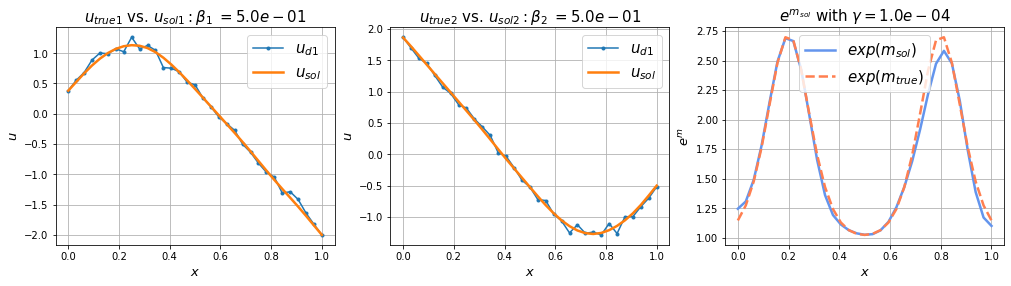

In [12]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, run.ud1.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[0].plot(x, u1.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true1}$ vs. $u_{sol1}: \beta_1$' + f' $ = {beta1:1.1e}$', fontsize=15)
ax[0].legend(prop={'size':15})

ax[1].plot(x, run.ud2.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[1].plot(x, u2.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true2}$ vs. $u_{sol2}: \beta_2$' + f' $ = {beta2:1.1e}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(m_true.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {run.gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/dual_helm_synth_{beta1:1.1f}_{beta2:1.1f}.eps', format='eps',dpi=250)
plt.show()

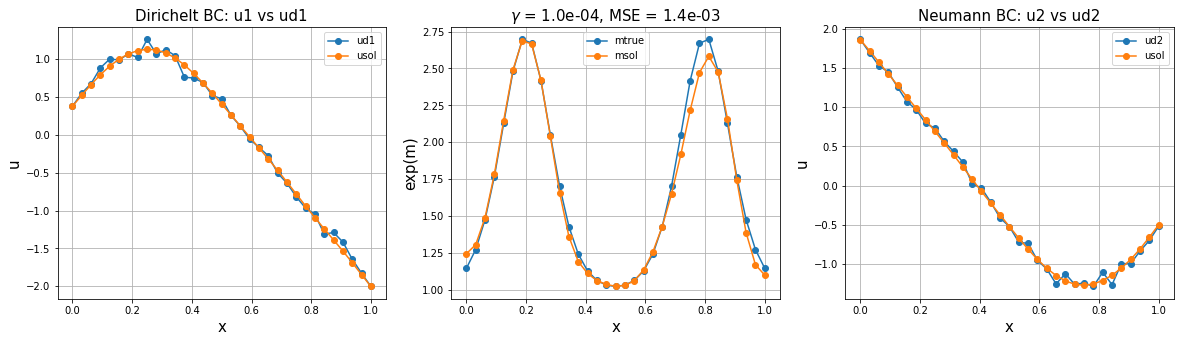

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5)) 
ax[0].plot(x,run.ud1.compute_vertex_values(), 'o-', label='ud1')
ax[0].plot(x,u1.compute_vertex_values(), 'o-', label='usol')
ax[0].set_xlabel('x', fontsize=15)
ax[0].set_ylabel('u', fontsize=15)
ax[0].set_title('Dirichelt BC: u1 vs ud1', fontsize=15)
ax[0].grid()
ax[0].legend()

mse = (np.square(m_true.compute_vertex_values() - m.compute_vertex_values())).mean()
ax[1].plot(x,np.exp(m_true.compute_vertex_values()), 'o-', label='mtrue')
ax[1].plot(x,np.exp(m.compute_vertex_values()), 'o-', label='msol')
ax[1].set_xlabel('x', fontsize=15)
ax[1].set_ylabel('exp(m)', fontsize=15)
ax[1].set_title(f'$\gamma$ = {run.gamma:1.1e}, MSE = {mse:1.1e}', fontsize=15)
ax[1].grid()
ax[1].legend()

ax[2].plot(x,run.ud2.compute_vertex_values(), 'o-', label='ud2')
ax[2].plot(x,u2.compute_vertex_values(), 'o-', label='usol')
ax[2].set_xlabel('x', fontsize=15)
ax[2].set_ylabel('u', fontsize=15)
ax[2].set_title('Neumann BC: u2 vs ud2', fontsize=15)
ax[2].grid()
ax[2].legend()

# plt.savefig('./log/img/dual_helm_synth.eps', format='eps', bbox_inches='tight')

0.3970093340851903


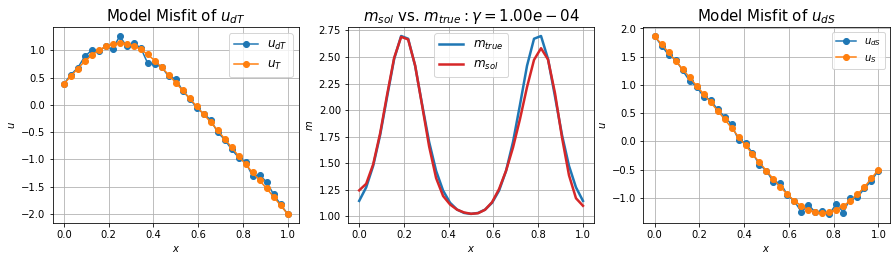

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.6)) 
ax[0].plot(x,run.ud1.compute_vertex_values(), 'o-', label=r'$u_{dT}$')
ax[0].plot(x,u1.compute_vertex_values(), 'o-', label=r'$u_{T}$')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u$')
ax[0].set_title(r'Model Misfit of $u_{dT}$', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)

mse = (np.square(m_true.compute_vertex_values() - m.compute_vertex_values())).mean()
ax[1].plot(x,np.exp(m_true.compute_vertex_values()), '-', label=r'$m_{true}$', linewidth=2.5,color = 'tab:blue')
ax[1].plot(x,np.exp(m.compute_vertex_values()), '-', label=r'$m_{sol}$', linewidth=2.5,color = 'tab:red')
# ax[1].set_title(f'gamma = {gamma[kappa_min_ind]:.3e}')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$m$')
ax[1].set_title(r'$m_{sol}$ vs. $m_{true}$'+f'$: \gamma = {run.gamma:1.2e}$', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

ax[2].plot(x,run.ud2.compute_vertex_values(), 'o-', label=r'$u_{dS}$')
ax[2].plot(x,u2.compute_vertex_values(), 'o-', label=r'$u_{S}$')
ax[2].set_xlabel(r'$x$')
ax[2].set_ylabel(r'$u$')
ax[2].set_title(r'Model Misfit of $u_{dS}$', fontsize=15)
ax[2].grid()
ax[2].legend()

print(np.linalg.norm(np.exp(m_true.compute_vertex_values()) - np.exp(m.compute_vertex_values())))
# plt.savefig('./log/img/dual_helm_synth.png', bbox_inches='tight',dpi=300)
# plt.savefig('./log/img/dual_helm_synth.eps', format='eps', bbox_inches='tight',dpi=300)

### EigenVal

25
26


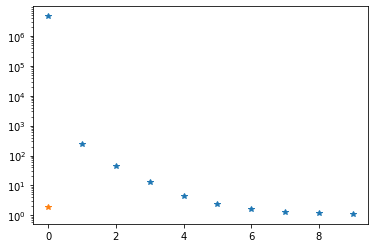

In [15]:
k = run.nx
lmbda, evecs = run.eigenvalue_request(m, p=20)

print(sum(lmbda >= 1.0))
print(sum(run.lmbda >= 1.0))

idx = 10
plt.semilogy(lmbda[:idx], '*')
plt.plot(run.lmbda[idx], '*')
dual_eig = lmbda.copy()

In [16]:
evecs[0].get_local()

array([-3162.18712158, -3162.18737663, -3162.18822793, -3162.18990665,
       -3162.19269397, -3162.19681136, -3162.20235067, -3162.2092758 ,
       -3162.21744318, -3162.22660794, -3162.23645669, -3162.24662968,
       -3162.25674974, -3162.26643483, -3162.27532336, -3162.28314355,
       -3162.28980186, -3162.29539516, -3162.30013377, -3162.30424934,
       -3162.30792633, -3162.31131785, -3162.31456653, -3162.3177908 ,
       -3162.32105188, -3162.32431858, -3162.32748403, -3162.3303963 ,
       -3162.33288672, -3162.33479825, -3162.33602169, -3162.33658064,
       -3162.33670936])

Text(0.5, 1.0, 'Eigenvector $v3$')

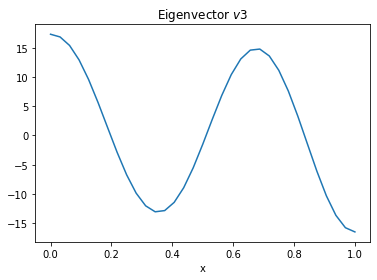

In [17]:
idx = 3
plt.plot(x,evecs[idx])
plt.xlabel('x')
plt.title(f'Eigenvector $v{idx}$')
# plt.savefig(f'./log/img/eigvec{idx}.eps', format='eps', bbox_inches='tight',dpi=300)
# plt.savefig(f'./log/img/eigvec{idx}.eps', format='eps',dpi=250)

In [ ]:
test1 = np.array([1.2123])
print(f'{test1.item()}')

1.2123


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


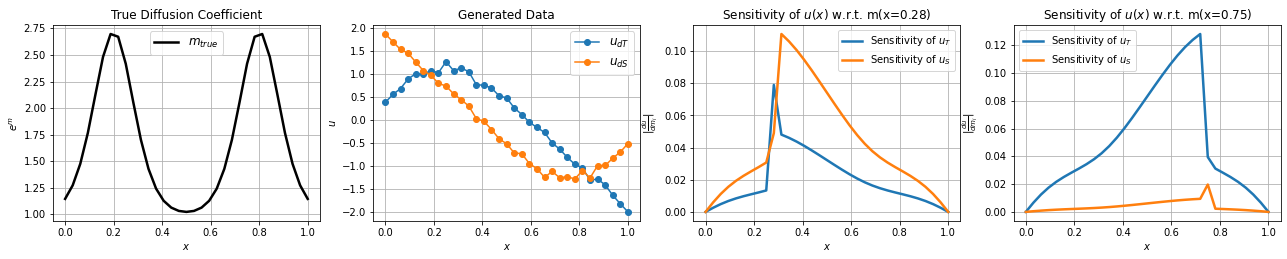

In [34]:
fig, ax = plt.subplots(ncols=4, figsize=(22, 3.6))

ax[0].plot(x, np.exp(mtrue_array), 'k', label='$m_{true}$', linewidth=2.5)
ax[0].legend(fontsize=12)
ax[0].set_title('True Diffusion Coefficient')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$e^m$')
ax[0].grid()

ax[1].plot(x, run.ud1.compute_vertex_values(), 'o-', label=r'$u_{dT}$', linewidth=1.5)
ax[1].plot(x, run.ud2.compute_vertex_values(), 'o-', label=r'$u_{dS}$', linewidth=1.5)
ax[1].legend(fontsize=12)
ax[1].set_title('Generated Data')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$u$')
ax[1].grid()

idx = 9
x_val = run.mesh.hmax() * idx
ax[2].plot(x, abs(sensitivity1[idx]), label=r'Sensitivity of $u_T$', linewidth=2.5)
ax[2].plot(x, abs(sensitivity2[idx]), label=r'Sensitivity of $u_S$', linewidth=2.5)
ax[2].set_ylabel(r'$|\frac{du}{dm_i}|$')
ax[2].set_xlabel(r'$x$')
ax[2].legend(fontsize=10)
ax[2].grid()
ax[2].set_title(f'Sensitivity of $u(x)$ w.r.t. m(x={x_val:.2f})')

idx = 24
x_val = run.mesh.hmax() * idx
ax[3].plot(x, abs(sensitivity1[idx]), label=r'Sensitivity of $u_T$', linewidth=2.5)
ax[3].plot(x, abs(sensitivity2[idx]), label=r'Sensitivity of $u_S$', linewidth=2.5)
ax[3].set_ylabel(r'$|\frac{du}{dm_i}|$')
ax[3].set_xlabel(r'$x$')
ax[3].legend(fontsize=10)
ax[3].grid()
ax[3].set_title(f'Sensitivity of $u(x)$ w.r.t. m(x={x_val:.2f})')

plt.savefig('./log/img/double_data_setupt_sensitivity.eps', format='eps', bbox_inches='tight',dpi=300)